In [40]:
import numpy as np
from matplotlib import pyplot as plt
import time
from multiprocessing import Pool

In [88]:
def timer(print_time = False):
    '''
        A decorator as timer.
    '''
    def decorator(func):
        def wrapper(*args, **kwargs):
            print(f"========================================")
            print(f"Timer activated.")
            start_time = time.time()
            if print_time:
                print(f"----------------------------------------")
                print(f"Start time: {time.asctime(time.localtime(start_time))}.")
                print(f"Running...")
            result = func(*args, **kwargs)
            end_time = time.time()
            if print_time:
                print(f"End   time: {time.asctime(time.localtime(end_time))}.")
                print(f"----------------------------------------")
            elapsed_time = end_time - start_time
            print("Time consuming: {0:.3f} s.".format(elapsed_time))
            print(f"========================================")
            return result
        return wrapper
    return decorator

# Response-Feedback function

In [42]:
def g_feedback(y_feedback):
    '''
        Feedback function.
    '''
    return 1/(1+y_feedback**4)

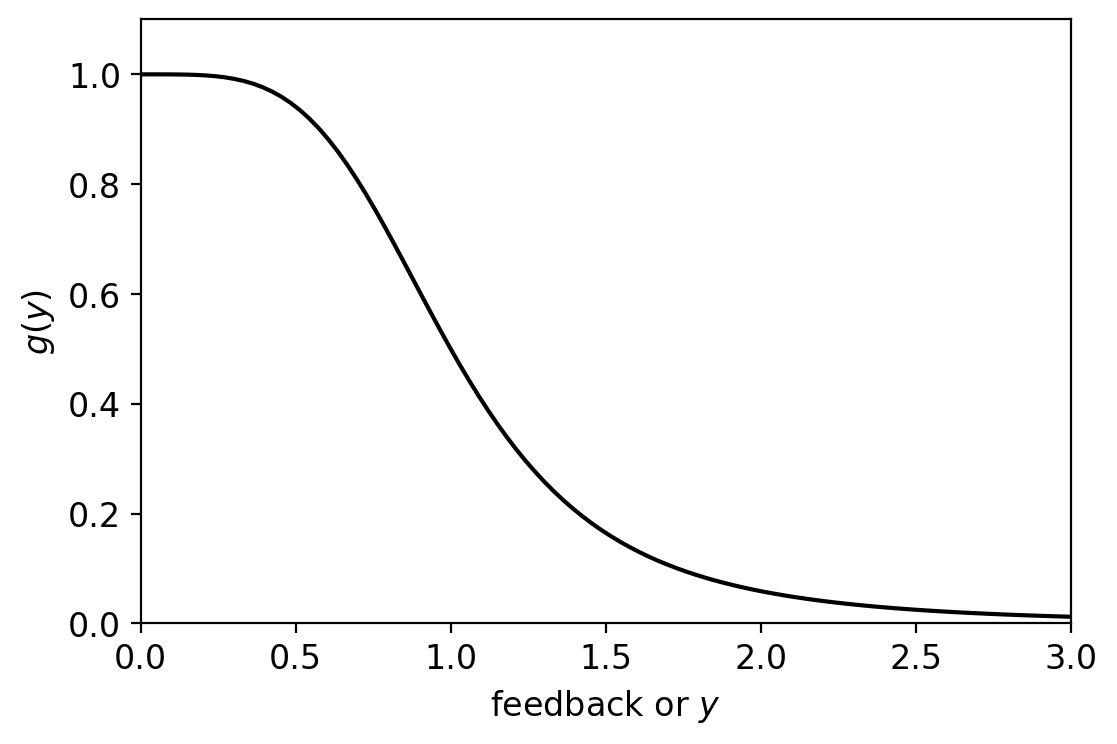

In [180]:
y = np.linspace(0, 3, 100)
x = g_feedback(y)
plt.figure(figsize = (6, 4), dpi = 200)
plt.rcParams.update({'font.size': 12})
plt.plot(y, x, color = 'k')
plt.ylim(0, 1.1)
plt.xlim(0, 3)
plt.xlabel('feedback or $y$')
plt.ylabel('$g(y)$')
plt.show()

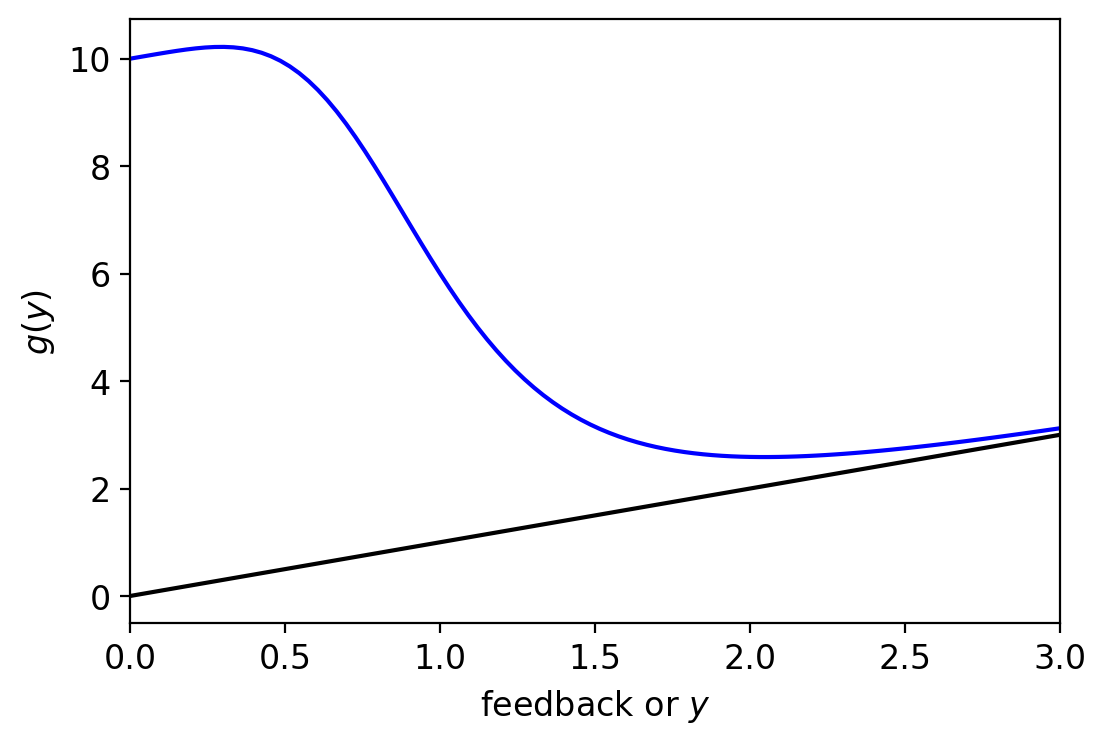

In [186]:
y = np.linspace(0, 3, 100)
x = g_feedback(y)
plt.figure(figsize = (6, 4), dpi = 200)
plt.rcParams.update({'font.size': 12})
plt.plot(y, 10 * x + y, color = 'b')
plt.plot(y, y, color = 'k')
#plt.ylim(0, 3)
plt.xlim(0, 3)
plt.xlabel('feedback or $y$')
plt.ylabel('$g(y)$')
plt.show()

In [127]:
def y2x(y_feedback, A):
    return A * g_feedback(y_feedback)

def lim_point_y2x_contrast(lim_point):
    lim_point_new = lim_point.copy()
    for i in range(len(lim_point_new[0])):
        lim_point_new[1][i] = y2x(lim_point_new[1][i], lim_point_new[0][i])
    return lim_point_new

def lim_point_y2x_frequency(lim_point, A):
    lim_point_new = lim_point.copy()
    for i in range(len(lim_point_new[0])):
        lim_point_new[1][i] = y2x(lim_point_new[1][i], A)
    return lim_point_new

In [94]:
#@timer(True)
def recurrence_relation(y_feedback, B, A, freq, tau):
    '''
        Recurrence relation for feedback amplitude.
    '''
    y_feedback_new = np.exp(-1 / freq / tau) * (B * A * g_feedback(y_feedback) + y_feedback)
    return y_feedback_new

In [90]:
# test
recurrence_relation(0.8, 10, 0.8, 10, 0.1)

Timer activated.
----------------------------------------
Start time: Wed Dec  2 17:05:52 2020.
Running...
End   time: Wed Dec  2 17:05:52 2020.
----------------------------------------
Time consuming: 0.000 s.


2.3821550919351235

# Attractor Finder

In [98]:
#@timer(True)
def bifurcation_map_attractor(B, A, freq, tau, N = 5000):
    x_series = []
    x_series.append(0)

    for i in range(N):
        x_series.append(recurrence_relation(x_series[-1], B, A, freq, tau))

    x_series_lim_4 = np.around(x_series[-100:], 4)
    return np.unique(x_series_lim_4)

In [124]:
bifurcation_map_attractor(1, 10, 10, 0.1, N = 5000)

array([0.9728, 2.2985])

In [10]:
B = 1
A = 30
freq = 10
tau = 0.1

A = np.linspace(0, 30, 200)

series_limits = []

for a in A:
    series_limits.append(bifurcation_map_attractor(B, a, freq, tau, N = 20000))

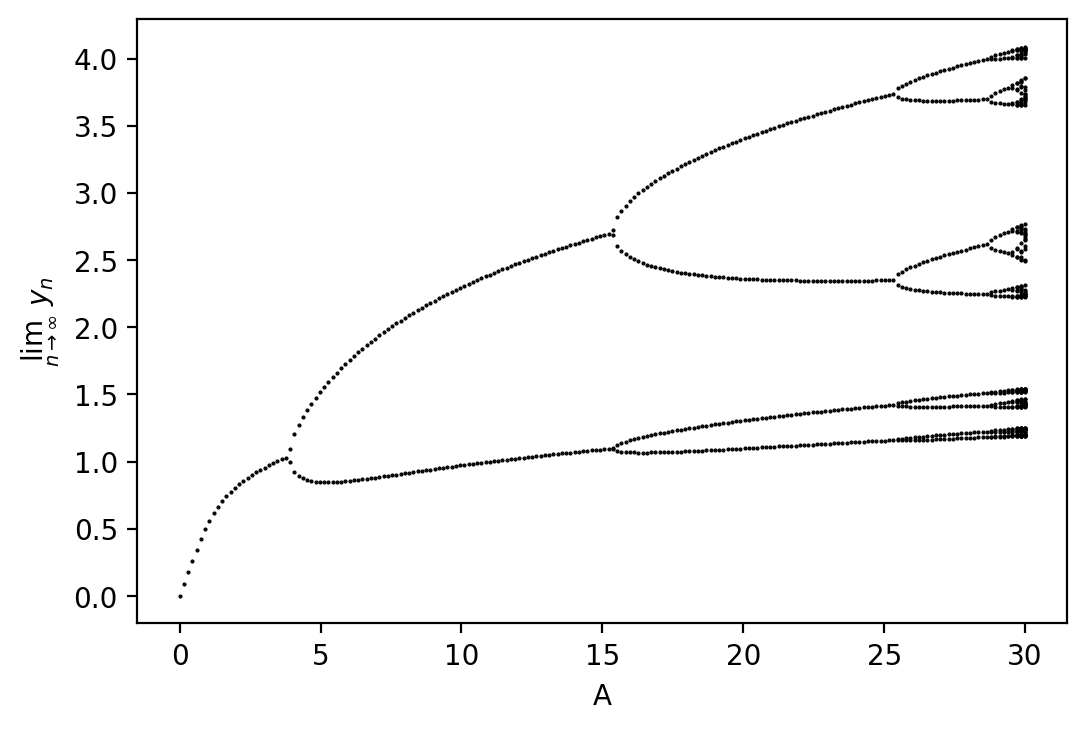

In [11]:
plt.figure(figsize=(6, 4), dpi=200)
for i in range(len(A)):
    for lim in series_limits[i]:
        plt.plot(A[i], lim, '.', c='k', markersize=1)
plt.xlabel('A')
plt.ylabel('$\lim_{n \\rightarrow \infty}~y_n$')
plt.show()

# Changing Contrast (A)

In [99]:
def bifurcation_map_lim_point_contrast(B, A, freq, tau, N = 20000):
    x_series_lim_unique = bifurcation_map_attractor(B, A, freq, tau, N = 20000)
    lim_point = np.zeros([2, len(x_series_lim_unique)])
    lim_point[0] = A * np.ones(len(x_series_lim_unique))
    lim_point[1] = x_series_lim_unique
    return lim_point

In [101]:
bifurcation_map_lim_point_contrast(B, 20, freq, tau)

array([[20.    , 20.    , 20.    , 20.    ],
       [ 1.098 ,  1.3064,  2.3612,  3.403 ]])

In [287]:
def bifurcation_map_lim_point_contrast_child(a, B = 1, freq = 10, tau = 0.1, N = 20000):
    lim_points = np.array([[], []])
    for A in a:
        lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_contrast(B, A, freq, tau, N)), axis=1)
    return lim_points

In [288]:
@timer(True)
def bifurcation_map_lim_point_contrast_multiprocessing(N_threads, As, B, freq, tau, N = 20000):

    As_split = np.split(As, N_threads)
    
    # create threads (out side of the loop to prevent memory leak)
    pool = Pool(processes = N_threads)
    
    # calculate
    results = pool.map(bifurcation_map_lim_point_contrast_child, As_split)

    # close threads
    pool.close()

    # processing results
    lim_points = np.array([[], []])
    for result in results:
        lim_points = np.concatenate((lim_points, result), axis=1)
        
    return lim_points

In [347]:
As = np.linspace(29, 29.999, 1000)
lim_points = bifurcation_map_lim_point_contrast_multiprocessing(N_threads = 5, As = As, B = 1, freq = 10, tau = 0.1, N = 20000)

Timer activated.
----------------------------------------
Start time: Fri Dec  4 15:26:21 2020.
Running...
End   time: Fri Dec  4 15:26:34 2020.
----------------------------------------
Time consuming: 13.053 s.


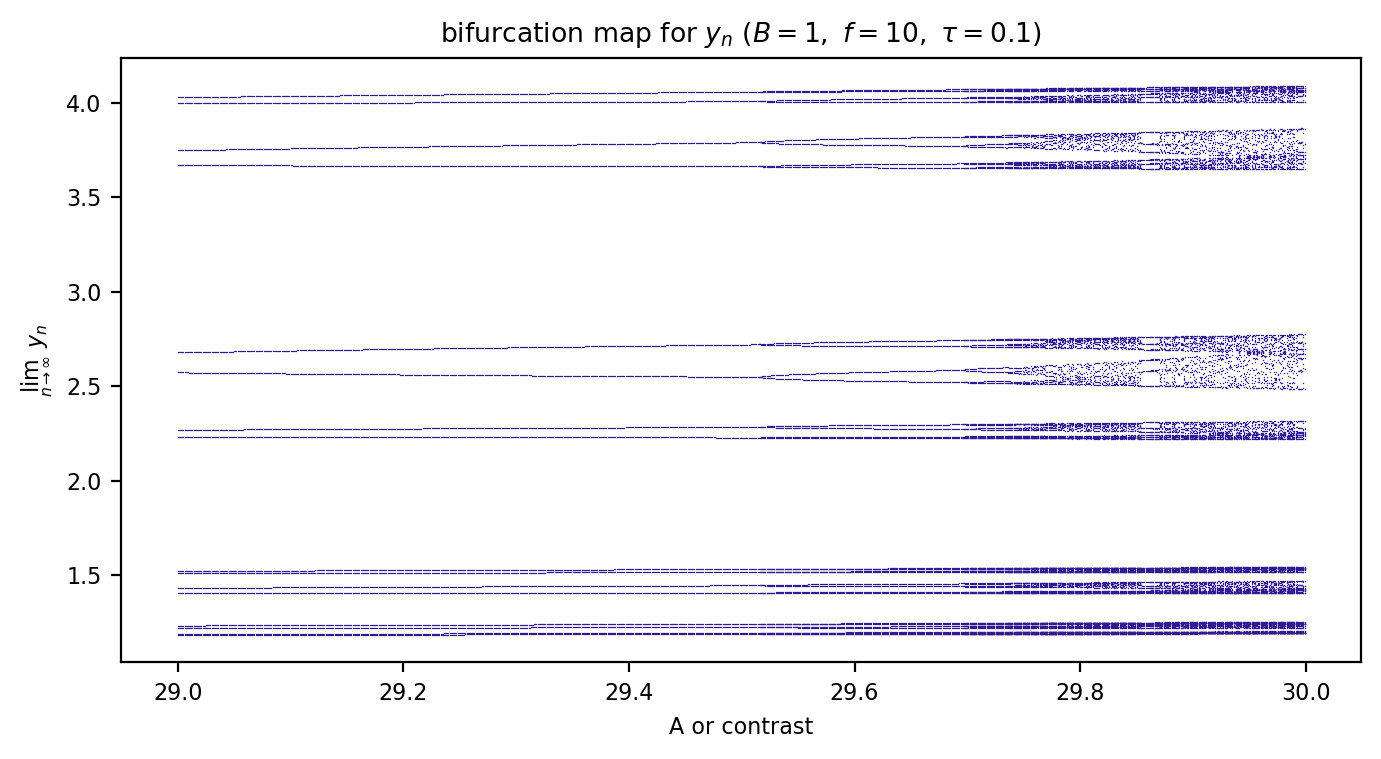

In [348]:
plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points[0], lim_points[1], c='#311B92', s = 1, marker = '.', alpha = 1, linewidths = 0)
#plt.xlim(0, 100)
#plt.ylim(0, 7)
plt.xlabel('A or contrast')
plt.ylabel('$\lim_{n \\rightarrow \infty}~y_n$')
plt.title('bifurcation map for $y_{n}$ ($B = 1,~f=10,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

In [321]:
np.where(lim_points[0] == 25.33) # 4 -> 8

(array([2132, 2133, 2134, 2135, 2136]),)

In [334]:
np.where(lim_points[0] == 28.69) # 8 -> 16

(array([], dtype=int64),)

In [345]:
np.where(lim_points[0] == 29.689999999999998) # 16 -> 32

(array([6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691,
        6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702,
        6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712]),)

In [346]:
(28.69 - 25.33) / (29.70 - 28.69)

3.3267326732673363

In [130]:
a = np.linspace(0, 100, 800)
a_split = np.split(a, 4)

# create threads (out side of the loop to prevent memory leak)
pool = Pool(processes = 4)

# set timer
start_time = time.time()

# calculate
results = pool.map(bifurcation_map_lim_point_contrast_child, a_split)

# close threads
pool.close()

# processing results
lim_points = np.array([[], []])
for result in results:
    lim_points = np.concatenate((lim_points, result), axis=1)

# print elapsed time
elapsed_time = time.time() - start_time
print("Time consuming: {0:.3f}s.".format(elapsed_time))

Time consuming: 8.934s.


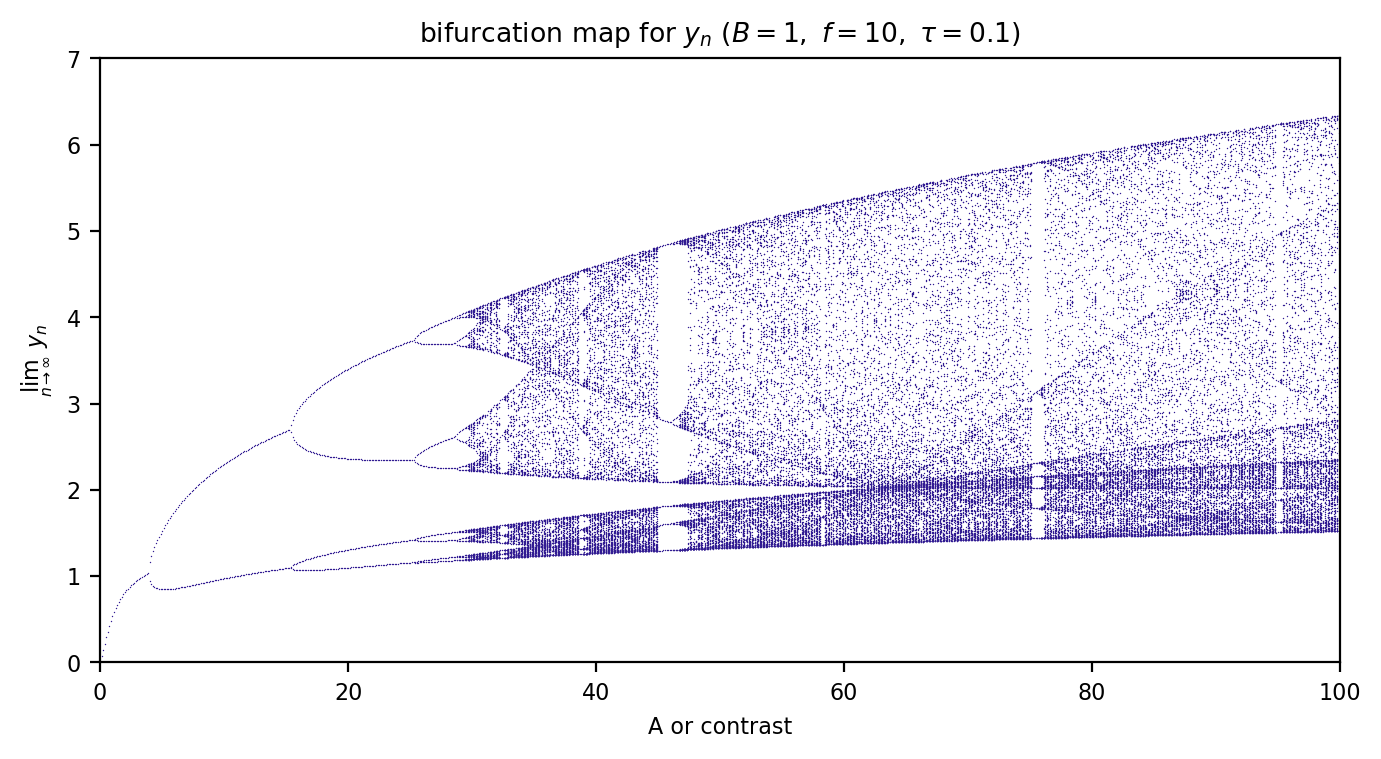

In [136]:
plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points[0], lim_points[1], c='#311B92', s = 1, marker = '.', alpha = 1, linewidths = 0)
plt.xlim(0, 100)
plt.ylim(0, 7)
plt.xlabel('A or contrast')
plt.ylabel('$\lim_{n \\rightarrow \infty}~y_n$')
plt.title('bifurcation map for $y_{n}$ ($B = 1,~f=10,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

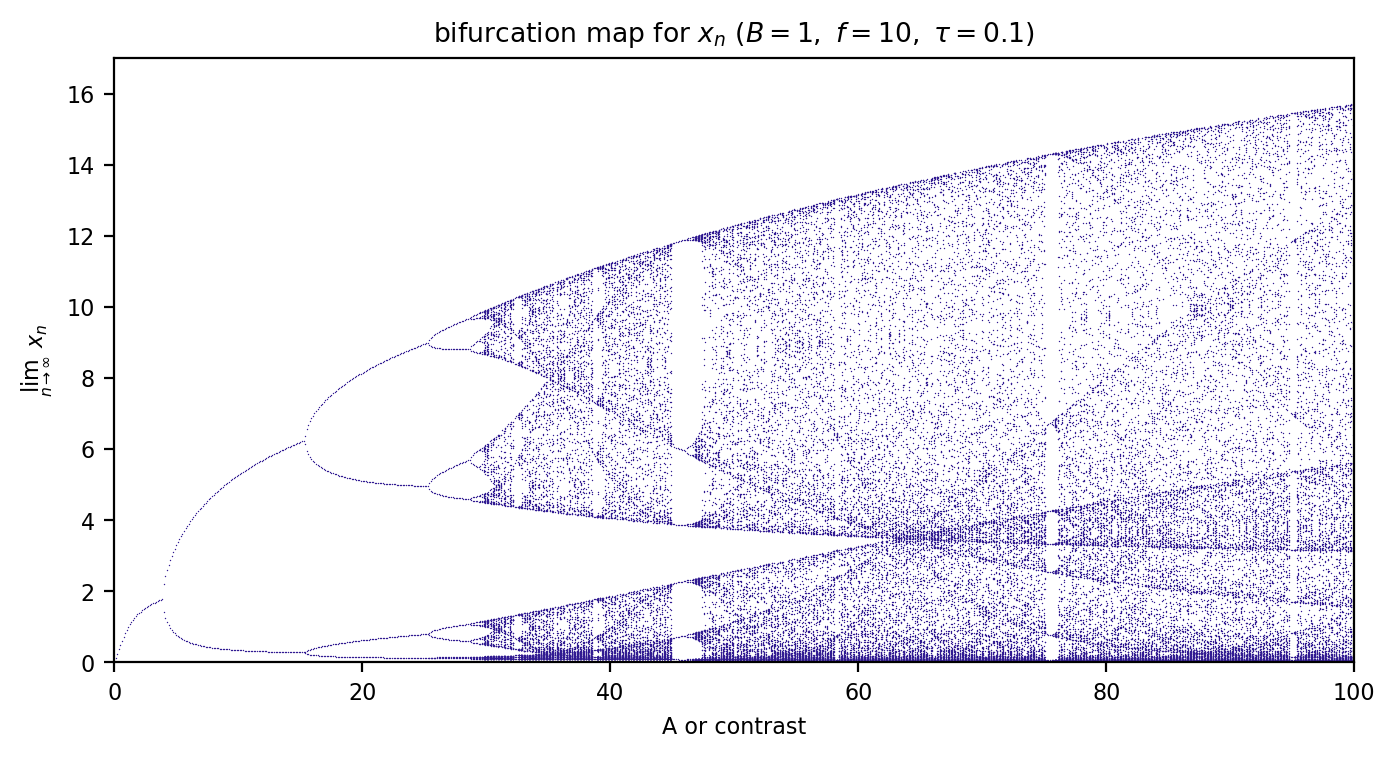

In [149]:
lim_points_x = lim_point_y2x_contrast(lim_points)
plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points_x[0], lim_points_x[1], c='#311B92', s = 1, marker = '.', alpha = 1, linewidths = 0)
plt.xlim(0, 100)
plt.ylim(0, 17)
plt.xlabel('A or contrast')
plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n$')
plt.title('bifurcation map for $x_{n}$ ($B = 1,~f=10,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

# Changing Frequency (f)

In [150]:
def bifurcation_map_lim_point_frequency(B, A, freq, tau, N = 20000):
    x_series_lim_unique = bifurcation_map_attractor(B, A, freq, tau, N = 20000)
    lim_point = np.zeros([2, len(x_series_lim_unique)])
    lim_point[0] = freq * np.ones(len(x_series_lim_unique))
    lim_point[1] = x_series_lim_unique
    return lim_point

In [193]:
def bifurcation_map_lim_point_frequency_child(f, A = 10, B = 1, tau = 0.1, N = 20000):
    lim_points = np.array([[], []])
    for freq in f:
        lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_frequency(B, A, freq, tau, N)), axis=1)
    return lim_points

In [196]:
f = np.linspace(0.1, 30, 500)
f_split = np.split(f, 4)

# create threads (out side of the loop to prevent memory leak)
pool = Pool(processes = 4)

# set timer
start_time = time.time()

# calculate
results = pool.map(bifurcation_map_lim_point_frequency_child, f_split)

# close threads
pool.close()

# processing results
lim_points = np.array([[], []])
for result in results:
    lim_points = np.concatenate((lim_points, result), axis=1)

# print elapsed time
elapsed_time = time.time() - start_time
print("Time consuming: {0:.3f}s.".format(elapsed_time))

Time consuming: 7.110s.


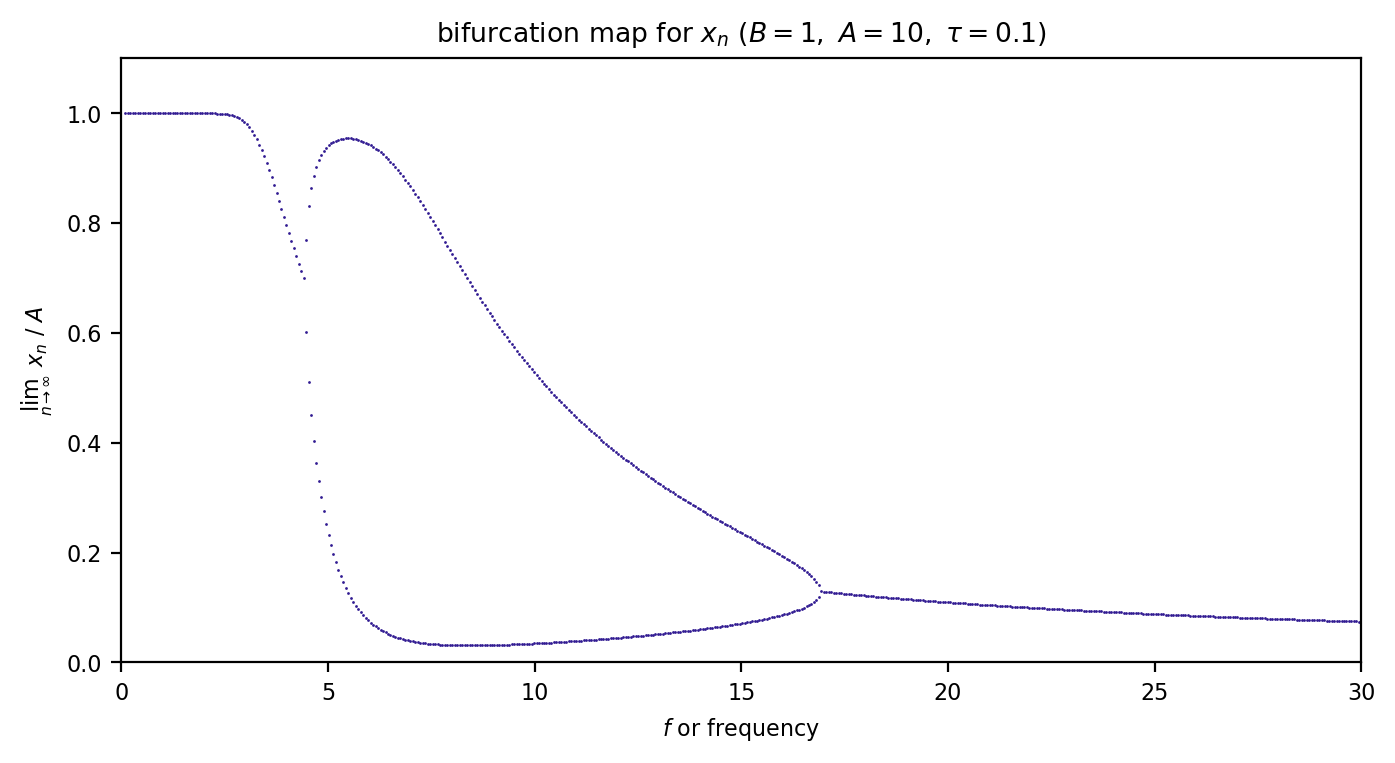

In [197]:
lim_points_x = lim_point_y2x_frequency(lim_points, 1)

plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points_x[0], lim_points_x[1], c='#311B92', s = 4, marker = '.', alpha = 1, linewidths = 0)
plt.xlim(0, 30)
plt.ylim(0, 1.1)
plt.xlabel('$f$ or frequency')
plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n~/~A$')
plt.title('bifurcation map for $x_{n}$ ($B = 1,~A=10,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

In [198]:
def bifurcation_map_lim_point_frequency_child(f, A = 20, B = 1, tau = 0.1, N = 20000):
    lim_points = np.array([[], []])
    for freq in f:
        lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_frequency(B, A, freq, tau, N)), axis=1)
    return lim_points

In [199]:
f = np.linspace(0.1, 30, 500)
f_split = np.split(f, 4)

# create threads (out side of the loop to prevent memory leak)
pool = Pool(processes = 4)

# set timer
start_time = time.time()

# calculate
results = pool.map(bifurcation_map_lim_point_frequency_child, f_split)

# close threads
pool.close()

# processing results
lim_points = np.array([[], []])
for result in results:
    lim_points = np.concatenate((lim_points, result), axis=1)

# print elapsed time
elapsed_time = time.time() - start_time
print("Time consuming: {0:.3f}s.".format(elapsed_time))

Time consuming: 7.330s.


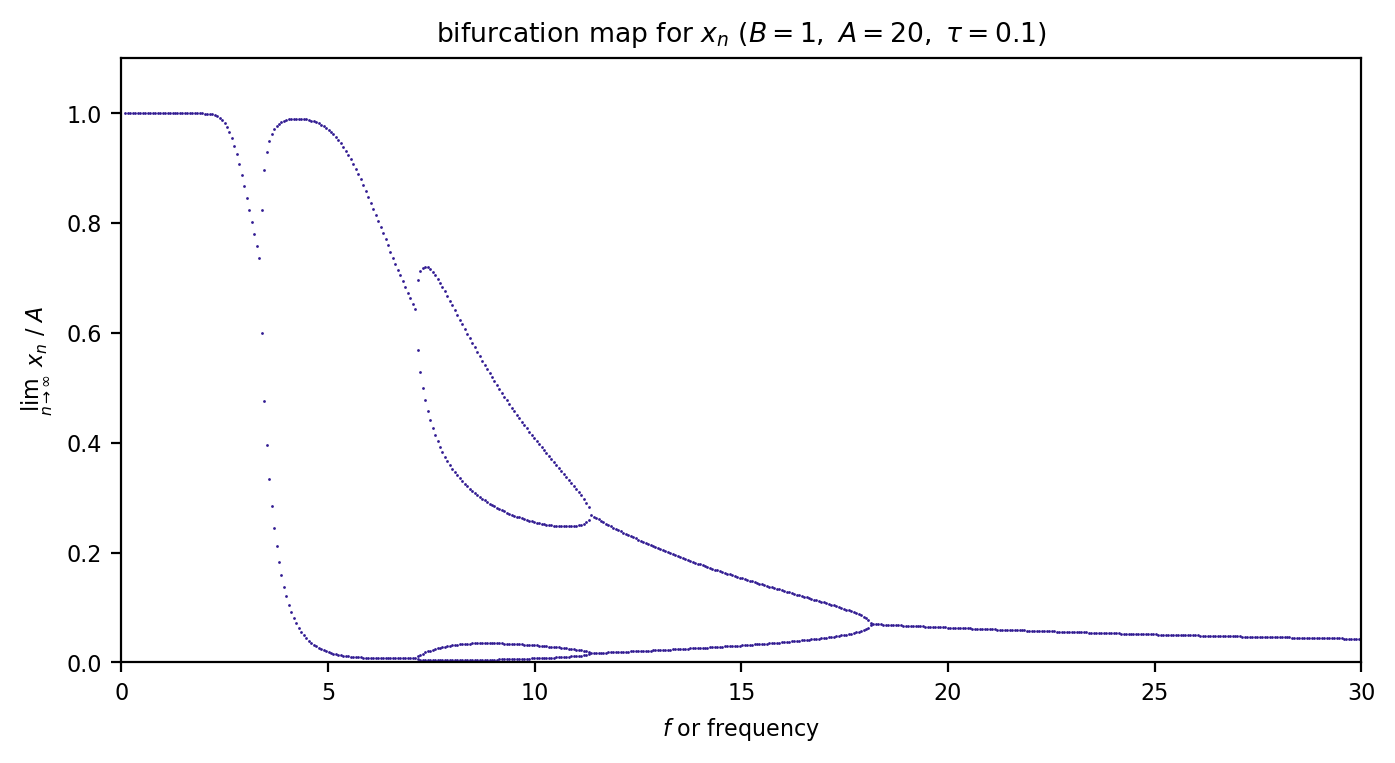

In [200]:
lim_points_x = lim_point_y2x_frequency(lim_points, 1)

plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points_x[0], lim_points_x[1], c='#311B92', s = 4, marker = '.', alpha = 1, linewidths = 0)
plt.xlim(0, 30)
plt.ylim(0, 1.1)
plt.xlabel('$f$ or frequency')
plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n~/~A$')
plt.title('bifurcation map for $x_{n}$ ($B = 1,~A=20,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

In [201]:
def bifurcation_map_lim_point_frequency_child(f, A = 26, B = 1, tau = 0.1, N = 20000):
    lim_points = np.array([[], []])
    for freq in f:
        lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_frequency(B, A, freq, tau, N)), axis=1)
    return lim_points

In [204]:
f = np.linspace(0.1, 30, 800)
f_split = np.split(f, 4)

# create threads (out side of the loop to prevent memory leak)
pool = Pool(processes = 4)

# set timer
start_time = time.time()

# calculate
results = pool.map(bifurcation_map_lim_point_frequency_child, f_split)

# close threads
pool.close()

# processing results
lim_points = np.array([[], []])
for result in results:
    lim_points = np.concatenate((lim_points, result), axis=1)

# print elapsed time
elapsed_time = time.time() - start_time
print("Time consuming: {0:.3f}s.".format(elapsed_time))

Time consuming: 10.990s.


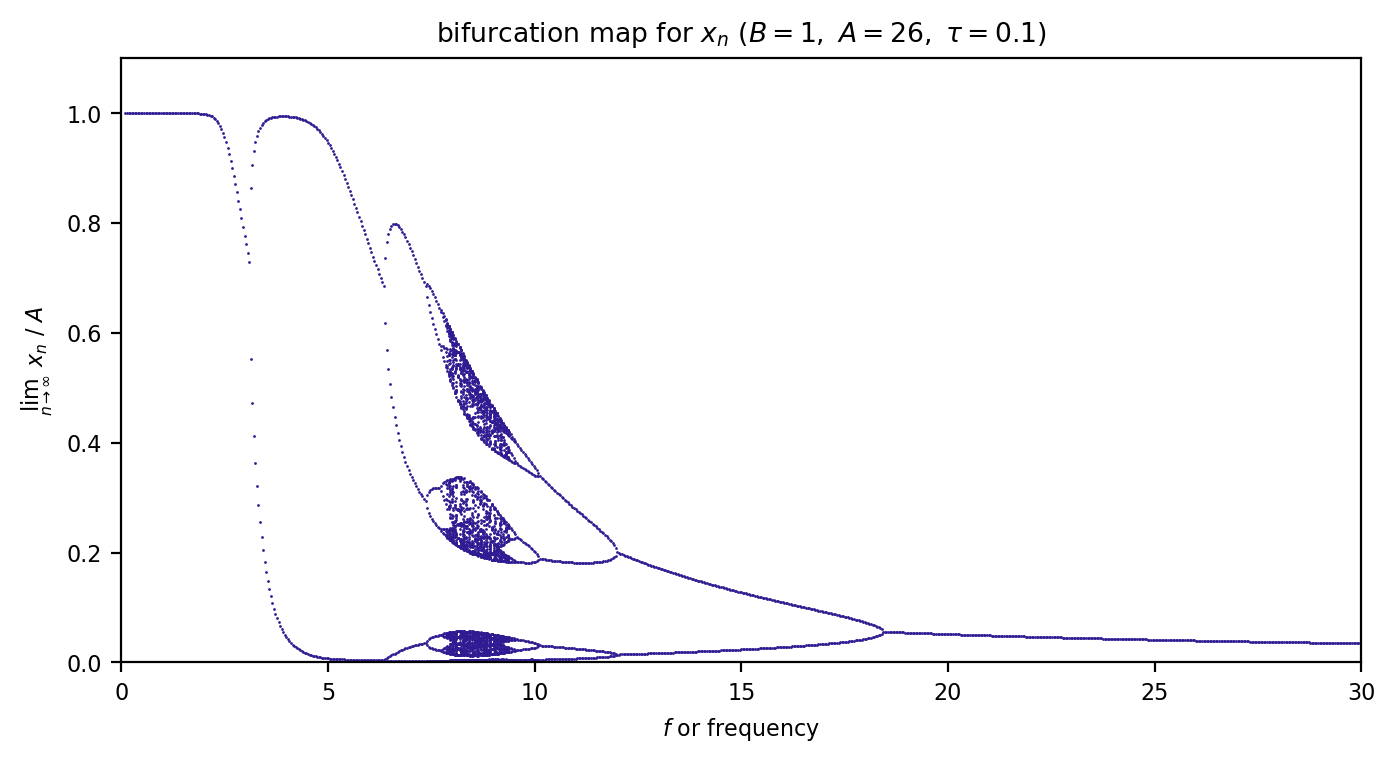

In [207]:
lim_points_x = lim_point_y2x_frequency(lim_points, 1)

plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points_x[0], lim_points_x[1], c='#311B92', s = 4, marker = '.', alpha = 1, linewidths = 0)
plt.xlim(0, 30)
plt.ylim(0, 1.1)
plt.xlabel('$f$ or frequency')
plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n~/~A$')
plt.title('bifurcation map for $x_{n}$ ($B = 1,~A=26,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

In [212]:
def bifurcation_map_lim_point_frequency_child(f, A = 40, B = 1, tau = 0.1, N = 20000):
    lim_points = np.array([[], []])
    for freq in f:
        lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_frequency(B, A, freq, tau, N)), axis=1)
    return lim_points

In [213]:
f = np.linspace(0.1, 30, 1000)
f_split = np.split(f, 4)

# create threads (out side of the loop to prevent memory leak)
pool = Pool(processes = 4)

# set timer
start_time = time.time()

# calculate
results = pool.map(bifurcation_map_lim_point_frequency_child, f_split)

# close threads
pool.close()

# processing results
lim_points = np.array([[], []])
for result in results:
    lim_points = np.concatenate((lim_points, result), axis=1)

# print elapsed time
elapsed_time = time.time() - start_time
print("Time consuming: {0:.3f}s.".format(elapsed_time))

Time consuming: 14.139s.


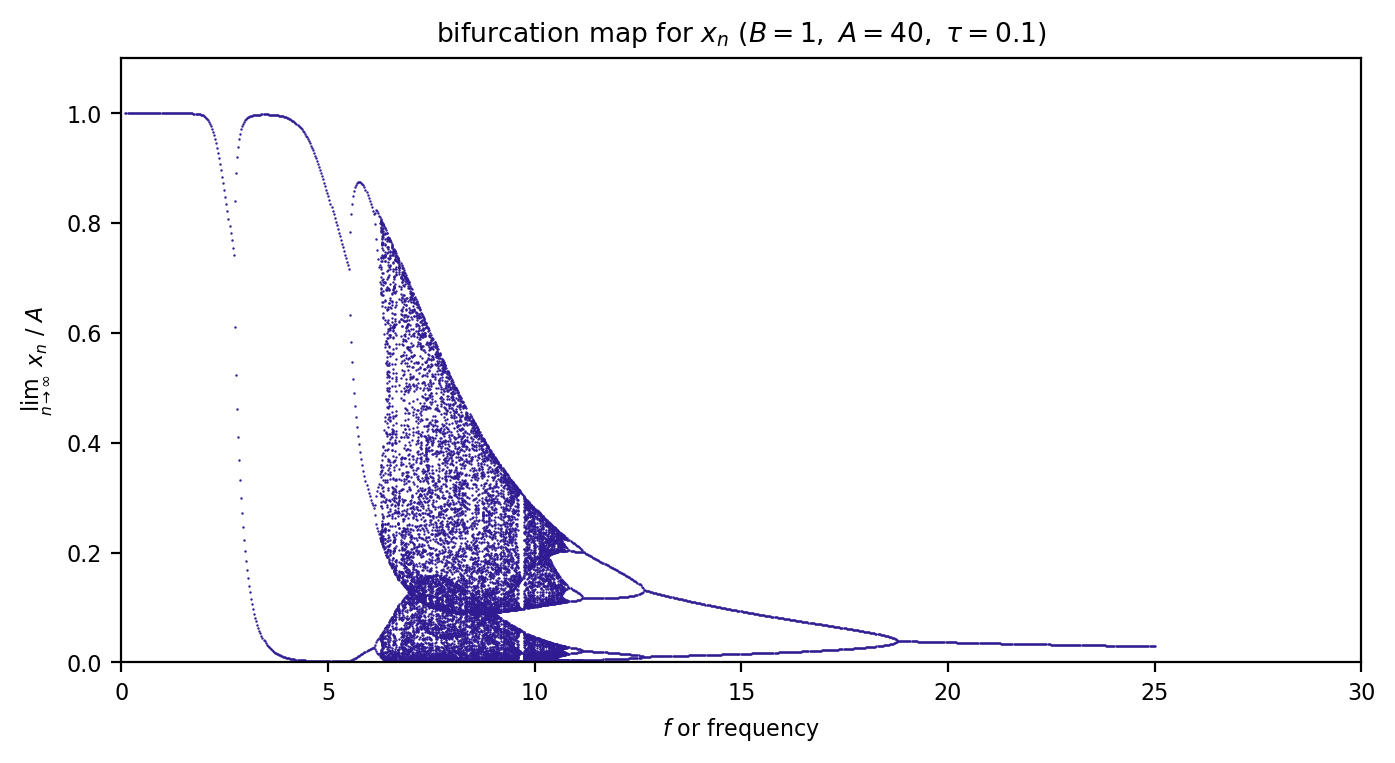

In [216]:
lim_points_x = lim_point_y2x_frequency(lim_points, 1)

plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points_x[0], lim_points_x[1], c='#311B92', s = 3, marker = '.', alpha = 1, linewidths = 0)
plt.xlim(0, 30)
plt.ylim(0, 1.1)
plt.xlabel('$f$ or frequency')
plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n~/~A$')
plt.title('bifurcation map for $x_{n}$ ($B = 1,~A=40,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

In [261]:
f = np.linspace(0.1, 30, 1000)
f_split = np.split(f, 4)

In [281]:
f_split_list = f_split.copy()
for i in range(len(f_split_list)):
    f_split_list[i] = f_split[i].tolist()
    
for i in range(len(f_split_list)):
    for j in range(len(f_split_list[i])):
        f_split_list[i][j] = (f_split_list[i][j], 10)

In [272]:
print(f"Start time: {time.asctime(time.localtime(time.time()))}.")

for A in np.arange(0, 100, 1):
    def bifurcation_map_lim_point_frequency_child(f, A = A, B = 1, tau = 0.1, N = 20000):
        lim_points = np.array([[], []])
        for freq in f:
            lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_frequency(B, A, freq, tau, N)), axis=1)
        return lim_points
    
    print(f"----------------------------------------")
    print(f"Start calculating for A = {A}...")
    f = np.linspace(0.1, 25, 1200)
    f_split = np.split(f, 6)

    # create threads (out side of the loop to prevent memory leak)
    pool = Pool(processes = 6)

    # set timer
    start_time = time.time()

    # calculate
    results = pool.map(bifurcation_map_lim_point_frequency_child, f_split)

    # close threads
    pool.close()

    # processing results
    lim_points = np.array([[], []])
    for result in results:
        lim_points = np.concatenate((lim_points, result), axis=1)

    # transform to x_n / A
    lim_points_x = lim_point_y2x_frequency(lim_points, 1)
    
    # plot
    plt.figure(figsize=(8, 4), dpi=200)
    plt.rcParams.update({'font.size': 8})
    plt.scatter(lim_points_x[0], lim_points_x[1], c='#311B92', s = 2, marker = '.', alpha = 1, linewidths = 0)
    plt.xlim(0, 25)
    plt.ylim(0, 1.1)
    plt.xlabel('$f$ or frequency')
    plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n~/~A$')
    plt.title(f"bifurcation map for $x_n$ ($B = 1,~A={A},~\\tau=0.1$)")
    plt.savefig('./bifurcation_map/A_' + str(A).zfill(3) + '.png', dpi = 200, format = 'png')
    plt.close()
    
    # print elapsed time
    elapsed_time = time.time() - start_time
    print("Time consuming: {0:.3f}s.".format(elapsed_time))
    
print(f"End time: {time.asctime(time.localtime(time.time()))}.")

Start time: Thu Dec  3 18:05:23 2020.
----------------------------------------
Start calculating for A = 0...


Process ForkPoolWorker-207:
Process ForkPoolWorker-209:


KeyboardInterrupt: 

Process ForkPoolWorker-211:
Process ForkPoolWorker-212:
Process ForkPoolWorker-210:
Process ForkPoolWorker-208:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jackblack/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jackblack/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/jackblack/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jackblack/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jackblack/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jackblack/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run

In [285]:
def bifurcation_map_lim_point_fA_child(fA, B = 1, tau = 0.1, N = 20000):
    lim_points = np.array([[], []])
    for (freq, A) in fA:
        lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_frequency(B, A, freq, tau, N)), axis=1)
    return lim_points

In [286]:
print(f"Start time: {time.asctime(time.localtime(time.time()))}.")

for A in np.arange(0, 1, 1):
    print(f"----------------------------------------")
    print(f"Start calculating for A = {A}...")
    f = np.linspace(0.1, 25, 1200)
    f_split = np.split(f, 6)
    
    # add A to fA
    f_split_list = f_split.copy()
    for i in range(len(f_split_list)):
        f_split_list[i] = f_split[i].tolist()

    for i in range(len(f_split_list)):
        for j in range(len(f_split_list[i])):
            f_split_list[i][j] = (f_split_list[i][j], A)

    # create threads (out side of the loop to prevent memory leak)
    pool = Pool(processes = 6)

    # set timer
    start_time = time.time()

    # calculate
    results = pool.map(bifurcation_map_lim_point_fA_child, f_split_list)

    # close threads
    pool.close()

    # processing results
    lim_points = np.array([[], []])
    for result in results:
        lim_points = np.concatenate((lim_points, result), axis=1)

    # transform to x_n / A
    lim_points_x = lim_point_y2x_frequency(lim_points, 1)
    
    # plot
    plt.figure(figsize=(8, 4), dpi=200)
    plt.rcParams.update({'font.size': 8})
    plt.scatter(lim_points_x[0], lim_points_x[1], c='#311B92', s = 2, marker = '.', alpha = 1, linewidths = 0)
    plt.xlim(0, 25)
    plt.ylim(0, 1.1)
    plt.xlabel('$f$ or frequency')
    plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n~/~A$')
    plt.title(f"bifurcation map for $x_n$ ($B = 1,~A={A},~\\tau=0.1$)")
    plt.savefig('./bifurcation_map/A_' + str(A).zfill(3) + '.png', dpi = 200, format = 'png')
    plt.close()
    
    # print elapsed time
    elapsed_time = time.time() - start_time
    print("Time consuming: {0:.3f}s.".format(elapsed_time))
    
print(f"End time: {time.asctime(time.localtime(time.time()))}.")

Start time: Thu Dec  3 18:13:29 2020.
----------------------------------------
Start calculating for A = 0...
Time consuming: 36.164s.
End time: Thu Dec  3 18:14:06 2020.


In [146]:
lim_points[1]

array([1.2000e-03, 1.7000e-03, 2.3000e-03, ..., 2.2919e+00, 2.2926e+00,
       2.2933e+00])

In [147]:
def y2x(y_feedback, A):
    return A * g_feedback(y_feedback)

def lim_point_y2x_contrast(lim_point):
    lim_point_new = lim_point.copy()
    for i in range(len(lim_point_new[0])):
        lim_point_new[1][i] = y2x(lim_point_new[1][i], lim_point_new[0][i])
    return lim_point_new

def lim_point_y2x_frequency(lim_point, A):
    lim_point_new = lim_point.copy()
    for i in range(len(lim_point_new[0])):
        lim_point_new[1][i] = y2x(lim_point_new[1][i], A)
    return lim_point_new

In [151]:
def lim_point_y2x_contrast(lim_point):
    lim_point_new = lim_point.copy()
    for i in range(len(lim_point_new[0])):
        lim_point_new[1][i] = y2x(lim_point_new[1][i], lim_point_new[0][i])
    return lim_point_new

In [150]:
def lim_point_y2x_frequency(lim_point, A):
    lim_point_new = lim_point.copy()
    for i in range(len(lim_point_new[0])):
        lim_point_new[1][i] = y2x(lim_point_new[1][i], A)
    return lim_point_new

In [152]:
A = 40

def bifurcation_map_lim_point_frequency_child(f, A = 40, B = 1, tau = 0.1, N = 20000):
    lim_points = np.array([[], []])
    for freq in f:
        lim_points = np.concatenate((lim_points, bifurcation_map_lim_point_frequency(B, A, freq, tau, N)), axis=1)
    return lim_points

f = np.linspace(1, 30, 800)
f_split = np.split(f, 4)

# create threads (out side of the loop to prevent memory leak)
pool = Pool(processes = 4)

# set timer
start_time = time.time()

# calculate
results = pool.map(bifurcation_map_lim_point_frequency_child, f_split)

# close threads
pool.close()

# processing results
lim_points = np.array([[], []])
for result in results:
    lim_points = np.concatenate((lim_points, result), axis=1)

# print elapsed time
elapsed_time = time.time() - start_time
print("Time consuming: {0:.3f}s.".format(elapsed_time))

lim_points = lim_point_y2x_frequency(lim_points, A)

Time consuming: 12.479s.


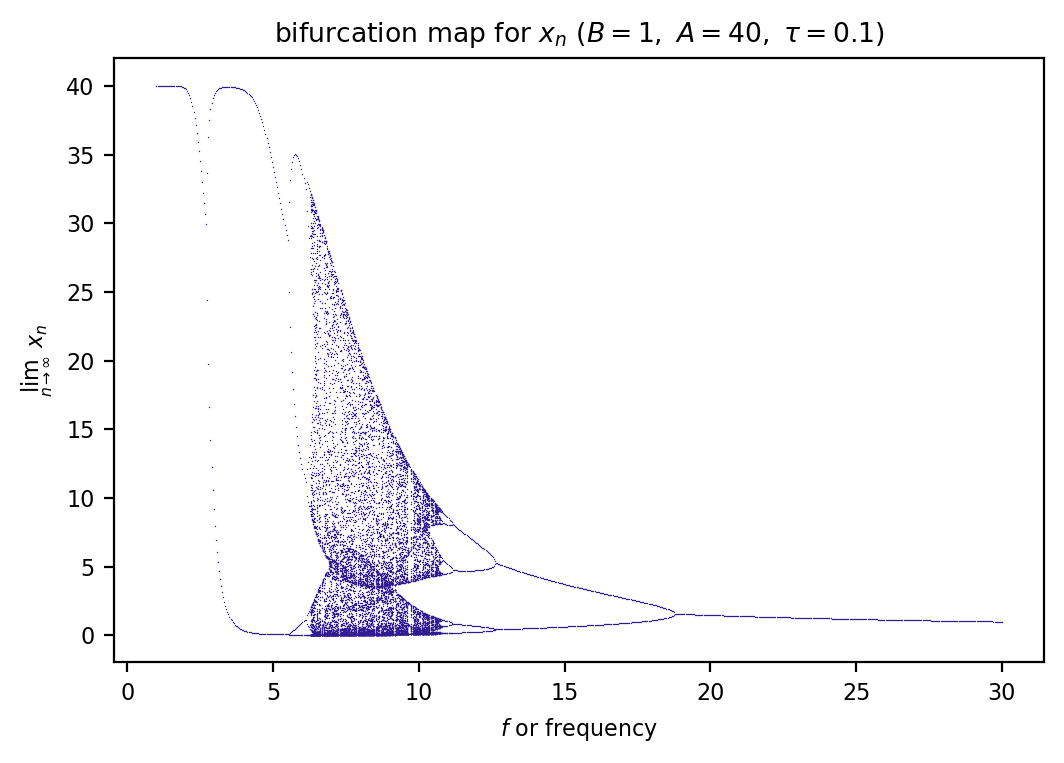

In [154]:
plt.figure(figsize=(6, 4), dpi=200)
plt.rcParams.update({'font.size': 8})
plt.scatter(lim_points[0], lim_points[1], c='#311B92', s = 1, marker = '.', alpha = 1, linewidths = 0)
plt.xlabel('$f$ or frequency')
plt.ylabel('$\lim_{n \\rightarrow \infty}~x_n$')
plt.title('bifurcation map for $x_{n}$ ($B = 1,~A=40,~\\tau=0.1$)')
#plt.savefig('./test.png', dpi = 200, format = 'png')
plt.show()

In [354]:
np.sqrt(2 * (11.2 ** 2 + (1 - 1/1.7) * 29.8 ** 2)) - 29.8

1.5401828141370189

In [350]:
(1 - 1/1.7)

0.4117647058823529

In [356]:
np.sqrt(11.2 ** 2 + 29.8 ** 2 * (np.sqrt(14/17) - 1)**2)

11.534327972031575

In [357]:
np.sqrt(3 / 17) * 29.8

12.518503951210407